In [26]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

In [27]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████▎                       | 6.5MB 10.3MB/s eta 0:00:02

In [ ]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [ ]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/RGB-img/img"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/RGB-img/img/'

centre_file = folder_path + files_all[15]
left_files_path_rev = []
right_files_path = []

for file in files_all[:31]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[30:61]:
  right_files_path.append(folder_path + file)

In [ ]:
from PIL.ExifTags import TAGS
from PIL.ExifTags import GPSTAGS
from PIL import Image
def get_exif(filename):
    image = Image.open(filename)
    image.verify()
    return image._getexif()
    
def get_labeled_exif(exif):
    labeled = {}
    for (key, val) in exif.items():
        labeled[TAGS.get(key)] = val

    return labeled


def get_geotagging(exif):
    if not exif:
        raise ValueError("No EXIF metadata found")

    geotagging = {}
    for (idx, tag) in TAGS.items():
        if tag == 'GPSInfo':
            if idx not in exif:
                raise ValueError("No EXIF geotagging found")

            for (key, val) in GPSTAGS.items():
                if key in exif[idx]:
                    geotagging[val] = exif[idx][key]
    return geotagging

def get_decimal_from_dms(dms, ref):

    degrees = dms[0][0] / dms[0][1]
    minutes = dms[1][0] / dms[1][1] / 60.0
    seconds = dms[2][0] / dms[2][1] / 3600.0

    if ref in ['S', 'W']:
        degrees = -degrees
        minutes = -minutes
        seconds = -seconds

    return round(degrees + minutes + seconds, 5)

def get_coordinates(geotags):
    lat = get_decimal_from_dms(geotags['GPSLatitude'], geotags['GPSLatitudeRef'])

    lon = get_decimal_from_dms(geotags['GPSLongitude'], geotags['GPSLongitudeRef'])

    return (lat,lon)

In [ ]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 31/31 [01:09<00:00,  2.26s/it]


In [ ]:
images_left_bgr_no_enhance = []
images_right_bgr_no_enhance = []


for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_left_bgr_no_enhance.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_right_bgr_no_enhance.append(right_img)

100%|██████████| 31/31 [00:11<00:00,  2.82it/s]


In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]

for imgs in tqdm(images_left_bgr):
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 31/31 [01:06<00:00,  2.14s/it]


In [ ]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh)
    inliers = inliers.flatten()
    return H, inliers

In [ ]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [ ]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.8,thresh=4,disp=False):
  FLANN_INDEX_KDTREE = 2
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  #flann = cv2.BFMatcher()

  lff1 = np.float32(descripts[0])
  lff = np.float32(descripts[1])


  matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)

  print("\nNumber of matches",len(matches_lf1_lf))

  matches_4 = []
  ratio = ratio
  # loop over the raw matches
  for m in matches_lf1_lf:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe’s ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])

  print("Number of matches After Lowe's Ratio",len(matches_4))
  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  
  Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  
  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  '''
  if len(inlier_matchset)<50:
    matches_4 = []
    ratio = 0.67
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
    '''
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [ ]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
print(left_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0031.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0030.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0029.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0028.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0027.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0026.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0025.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0024.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0023.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0022.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0021.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0020.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0019.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0018.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0017.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [ ]:
print(right_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0031.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0032.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0033.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0034.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0035.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0036.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0037.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0038.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0039.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0040.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0041.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0042.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0043.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0044.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0045.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [ ]:
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.5)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.5)
  H_right_sift.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

  3%|▎         | 1/31 [00:06<03:10,  6.34s/it]


Number of matches 38187
Number of matches After Lowe's Ratio 429
Number of Robust matches 263




  6%|▋         | 2/31 [00:12<02:59,  6.19s/it]


Number of matches 35025
Number of matches After Lowe's Ratio 131
Number of Robust matches 93




 10%|▉         | 3/31 [00:17<02:43,  5.82s/it]


Number of matches 35065
Number of matches After Lowe's Ratio 1070
Number of Robust matches 741




 13%|█▎        | 4/31 [00:22<02:31,  5.60s/it]


Number of matches 32733
Number of matches After Lowe's Ratio 1216
Number of Robust matches 957




 16%|█▌        | 5/31 [00:26<02:17,  5.29s/it]


Number of matches 33968
Number of matches After Lowe's Ratio 1166
Number of Robust matches 975




 19%|█▉        | 6/31 [00:32<02:11,  5.28s/it]


Number of matches 39070
Number of matches After Lowe's Ratio 1515
Number of Robust matches 1156




 23%|██▎       | 7/31 [00:38<02:17,  5.73s/it]


Number of matches 41604
Number of matches After Lowe's Ratio 1061
Number of Robust matches 699




 26%|██▌       | 8/31 [00:45<02:19,  6.05s/it]


Number of matches 43881
Number of matches After Lowe's Ratio 968
Number of Robust matches 624




 29%|██▉       | 9/31 [00:52<02:18,  6.30s/it]


Number of matches 40123
Number of matches After Lowe's Ratio 950
Number of Robust matches 628




 32%|███▏      | 10/31 [00:58<02:11,  6.28s/it]


Number of matches 36596
Number of matches After Lowe's Ratio 1219
Number of Robust matches 882




 35%|███▌      | 11/31 [01:03<01:59,  5.96s/it]


Number of matches 33986
Number of matches After Lowe's Ratio 1603
Number of Robust matches 1356




 39%|███▊      | 12/31 [01:08<01:46,  5.59s/it]


Number of matches 30652
Number of matches After Lowe's Ratio 1742
Number of Robust matches 1464




 42%|████▏     | 13/31 [01:12<01:32,  5.12s/it]


Number of matches 29868
Number of matches After Lowe's Ratio 2040
Number of Robust matches 1747




 45%|████▌     | 14/31 [01:16<01:21,  4.78s/it]


Number of matches 28588
Number of matches After Lowe's Ratio 1920
Number of Robust matches 1557




 48%|████▊     | 15/31 [01:20<01:11,  4.49s/it]


Number of matches 28661
Number of matches After Lowe's Ratio 2392
Number of Robust matches 1657




 52%|█████▏    | 16/31 [01:24<01:03,  4.24s/it]


Number of matches 27785
Number of matches After Lowe's Ratio 2587
Number of Robust matches 1884




 55%|█████▍    | 17/31 [01:27<00:56,  4.03s/it]


Number of matches 27261
Number of matches After Lowe's Ratio 2560
Number of Robust matches 1658




 58%|█████▊    | 18/31 [01:31<00:49,  3.84s/it]


Number of matches 23943
Number of matches After Lowe's Ratio 1433
Number of Robust matches 1186




 61%|██████▏   | 19/31 [01:34<00:43,  3.60s/it]


Number of matches 23206
Number of matches After Lowe's Ratio 2824
Number of Robust matches 2486




 65%|██████▍   | 20/31 [01:37<00:37,  3.39s/it]


Number of matches 27133
Number of matches After Lowe's Ratio 2517
Number of Robust matches 2289




 68%|██████▊   | 21/31 [01:40<00:34,  3.47s/it]


Number of matches 28897
Number of matches After Lowe's Ratio 1398
Number of Robust matches 1145




 71%|███████   | 22/31 [01:44<00:32,  3.59s/it]


Number of matches 30356
Number of matches After Lowe's Ratio 1369
Number of Robust matches 1166




 74%|███████▍  | 23/31 [01:48<00:30,  3.75s/it]


Number of matches 30770
Number of matches After Lowe's Ratio 1950
Number of Robust matches 1586




 77%|███████▋  | 24/31 [01:52<00:27,  3.89s/it]


Number of matches 30376
Number of matches After Lowe's Ratio 1293
Number of Robust matches 957




 81%|████████  | 25/31 [01:57<00:24,  4.00s/it]


Number of matches 30122
Number of matches After Lowe's Ratio 1634
Number of Robust matches 1301




 84%|████████▍ | 26/31 [02:01<00:20,  4.01s/it]


Number of matches 30579
Number of matches After Lowe's Ratio 1462
Number of Robust matches 898




 87%|████████▋ | 27/31 [02:05<00:16,  4.02s/it]


Number of matches 29556
Number of matches After Lowe's Ratio 2251
Number of Robust matches 1317




 90%|█████████ | 28/31 [02:09<00:12,  4.02s/it]


Number of matches 30860
Number of matches After Lowe's Ratio 1130
Number of Robust matches 550




 94%|█████████▎| 29/31 [02:13<00:08,  4.04s/it]


Number of matches 30396
Number of matches After Lowe's Ratio 1899
Number of Robust matches 929




  0%|          | 0/31 [00:00<?, ?it/s]


Number of matches 26655
Number of matches After Lowe's Ratio 445
Number of Robust matches 229




  3%|▎         | 1/31 [00:06<03:04,  6.15s/it]


Number of matches 39115
Number of matches After Lowe's Ratio 1102
Number of Robust matches 778




  6%|▋         | 2/31 [00:11<02:54,  6.00s/it]


Number of matches 34271
Number of matches After Lowe's Ratio 573
Number of Robust matches 419




 10%|▉         | 3/31 [00:16<02:40,  5.74s/it]


Number of matches 35656
Number of matches After Lowe's Ratio 1067
Number of Robust matches 660




 13%|█▎        | 4/31 [00:21<02:29,  5.53s/it]


Number of matches 30633
Number of matches After Lowe's Ratio 1077
Number of Robust matches 794




 16%|█▌        | 5/31 [00:26<02:15,  5.21s/it]


Number of matches 35893
Number of matches After Lowe's Ratio 1035
Number of Robust matches 787




 19%|█▉        | 6/31 [00:31<02:09,  5.20s/it]


Number of matches 31039
Number of matches After Lowe's Ratio 1018
Number of Robust matches 693




 23%|██▎       | 7/31 [00:35<01:58,  4.94s/it]


Number of matches 31666
Number of matches After Lowe's Ratio 1271
Number of Robust matches 1037




 26%|██▌       | 8/31 [00:40<01:50,  4.79s/it]


Number of matches 31209
Number of matches After Lowe's Ratio 1771
Number of Robust matches 1303




 29%|██▉       | 9/31 [00:44<01:41,  4.63s/it]


Number of matches 32208
Number of matches After Lowe's Ratio 1628
Number of Robust matches 1359




 32%|███▏      | 10/31 [00:49<01:36,  4.60s/it]


Number of matches 29913
Number of matches After Lowe's Ratio 1924
Number of Robust matches 1268




 35%|███▌      | 11/31 [00:53<01:27,  4.39s/it]


Number of matches 28182
Number of matches After Lowe's Ratio 2450
Number of Robust matches 1994




 39%|███▊      | 12/31 [00:56<01:19,  4.17s/it]


Number of matches 27052
Number of matches After Lowe's Ratio 3172
Number of Robust matches 2892




 42%|████▏     | 13/31 [01:00<01:11,  3.96s/it]


Number of matches 26581
Number of matches After Lowe's Ratio 2753
Number of Robust matches 2378




 45%|████▌     | 14/31 [01:03<01:03,  3.75s/it]


Number of matches 25919
Number of matches After Lowe's Ratio 1957
Number of Robust matches 1713




 48%|████▊     | 15/31 [01:06<00:57,  3.59s/it]


Number of matches 27099
Number of matches After Lowe's Ratio 2091
Number of Robust matches 1878




 52%|█████▏    | 16/31 [01:10<00:53,  3.58s/it]


Number of matches 27282
Number of matches After Lowe's Ratio 1670
Number of Robust matches 1334




 55%|█████▍    | 17/31 [01:13<00:50,  3.61s/it]


Number of matches 27592
Number of matches After Lowe's Ratio 2388
Number of Robust matches 1965




 58%|█████▊    | 18/31 [01:17<00:46,  3.57s/it]


Number of matches 24162
Number of matches After Lowe's Ratio 1371
Number of Robust matches 1209




 61%|██████▏   | 19/31 [01:20<00:40,  3.40s/it]


Number of matches 27909
Number of matches After Lowe's Ratio 1446
Number of Robust matches 1179




 65%|██████▍   | 20/31 [01:23<00:37,  3.45s/it]


Number of matches 23666
Number of matches After Lowe's Ratio 1287
Number of Robust matches 781




 68%|██████▊   | 21/31 [01:26<00:33,  3.32s/it]


Number of matches 31966
Number of matches After Lowe's Ratio 515
Number of Robust matches 369




 71%|███████   | 22/31 [01:31<00:32,  3.61s/it]


Number of matches 27613
Number of matches After Lowe's Ratio 1245
Number of Robust matches 955




 74%|███████▍  | 23/31 [01:35<00:29,  3.71s/it]


Number of matches 32877
Number of matches After Lowe's Ratio 763
Number of Robust matches 574




 77%|███████▋  | 24/31 [01:39<00:28,  4.02s/it]


Number of matches 32266
Number of matches After Lowe's Ratio 1840
Number of Robust matches 1115




 81%|████████  | 25/31 [01:44<00:25,  4.21s/it]


Number of matches 32463
Number of matches After Lowe's Ratio 1604
Number of Robust matches 997




 84%|████████▍ | 26/31 [01:49<00:22,  4.41s/it]


Number of matches 32125
Number of matches After Lowe's Ratio 1740
Number of Robust matches 1073




 87%|████████▋ | 27/31 [01:54<00:17,  4.47s/it]


Number of matches 32332
Number of matches After Lowe's Ratio 1449
Number of Robust matches 821




 90%|█████████ | 28/31 [01:58<00:13,  4.52s/it]


Number of matches 35330
Number of matches After Lowe's Ratio 57
Number of Robust matches 47




 94%|█████████▎| 29/31 [02:03<00:09,  4.66s/it]


Number of matches 28871
Number of matches After Lowe's Ratio 365
Number of Robust matches 305




 97%|█████████▋| 30/31 [02:07<00:04,  4.45s/it]


Number of matches 30330
Number of matches After Lowe's Ratio 587
Number of Robust matches 495




In [ ]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]



    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht

In [ ]:
def final_steps_left(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_left = []


    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)

    print('Step31:Done')

    return warp_imgs_left

def final_steps_right(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_right = []

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step32:Done')

    return warp_imgs_right

def final_steps_union(warp_imgs_left,warp_imgs_right):
    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]



    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      black_pixels = np.where((warp_img_init[:, :, 0] == 0) & (warp_img_init[:, :, 1] == 0) & (warp_img_init[:, :, 2] == 0))

      warp_img_init[black_pixels] = warp_images_all[j+1][black_pixels]
    
      #warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      #warp_img_init = warp_final
      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_img_init

In [ ]:
def final_steps_left_union(images_left,H_left,xmax,xmin,ymax,ymin,t,h,w,Ht):



    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))
      warp_img_init_curr = result

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
        warp_img_init_prev = result
        continue
      
      black_pixels = np.where((warp_img_init_prev[:, :, 0] == 0) & (warp_img_init_prev[:, :, 1] == 0) & (warp_img_init_prev[:, :, 2] == 0))

      warp_img_init_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step31:Done')

    return warp_img_init_prev

def final_steps_right_union(warp_img_prev,images_right,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      warp_img_init_curr = result

      black_pixels = np.where((warp_img_prev[:, :, 0] == 0) & (warp_img_prev[:, :, 1] == 0) & (warp_img_prev[:, :, 2] == 0))

      warp_img_prev[black_pixels] = warp_img_init_curr[black_pixels]
      
    print('Step32:Done')

    return warp_img_prev

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_sift,H_right_sift)

Step1:Done
Step2:Done


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_sift,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step31:Done


In [ ]:
warp_imgs_all_sift = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_sift,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done


Text(0.5, 1.0, '61-Images Mosaic-SIFT')

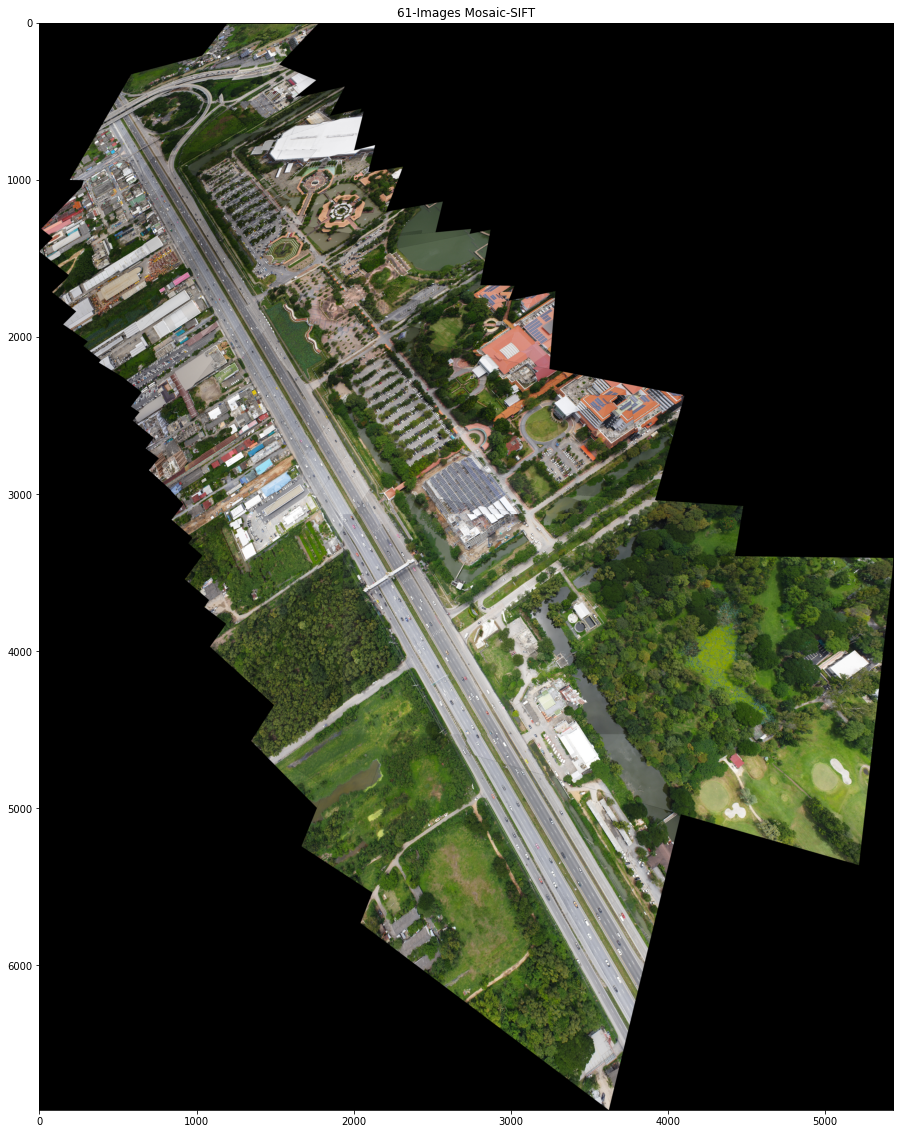

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_sift , cv2.COLOR_BGR2RGB))
ax.set_title('61-Images Mosaic-SIFT')

In [28]:
akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for imgs in tqdm(images_left_bgr):
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))


100%|██████████| 31/31 [00:32<00:00,  1.04s/it]

100%|██████████| 31/31 [00:31<00:00,  1.02s/it]


In [29]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh)
    inliers = inliers.flatten()
    return H, inliers

In [30]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [31]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.8,thresh=4,disp=False):
  FLANN_INDEX_KDTREE = 2
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  #flann = cv2.BFMatcher()

  lff1 = np.float32(descripts[0])
  lff = np.float32(descripts[1])


  matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)

  print("\nNumber of matches",len(matches_lf1_lf))

  matches_4 = []
  ratio = ratio
  # loop over the raw matches
  for m in matches_lf1_lf:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe’s ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])

  print("Number of matches After Lowe's Ratio",len(matches_4))
  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  
  Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  
  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  '''
  if len(inlier_matchset)<50:
    matches_4 = []
    ratio = 0.67
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
    '''
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [32]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [33]:
print(left_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0031.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0030.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0029.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0028.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0027.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0026.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0025.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0024.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0023.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0022.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0021.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0020.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0019.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0018.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0017.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [34]:

print(right_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0031.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0032.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0033.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0034.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0035.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0036.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0037.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0038.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0039.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0040.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0041.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0042.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0043.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0044.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0045.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [35]:
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

  3%|▎         | 1/31 [00:01<00:44,  1.49s/it]


Number of matches 23539
Number of matches After Lowe's Ratio 934
Number of Robust matches 303




  6%|▋         | 2/31 [00:02<00:41,  1.45s/it]


Number of matches 19832
Number of matches After Lowe's Ratio 496
Number of Robust matches 80




 10%|▉         | 3/31 [00:03<00:37,  1.35s/it]


Number of matches 19393
Number of matches After Lowe's Ratio 1860
Number of Robust matches 1160




 13%|█▎        | 4/31 [00:04<00:33,  1.25s/it]


Number of matches 17976
Number of matches After Lowe's Ratio 2010
Number of Robust matches 1244




 16%|█▌        | 5/31 [00:06<00:31,  1.20s/it]


Number of matches 19408
Number of matches After Lowe's Ratio 2008
Number of Robust matches 1293




 19%|█▉        | 6/31 [00:07<00:29,  1.17s/it]


Number of matches 23039
Number of matches After Lowe's Ratio 2412
Number of Robust matches 1372




 23%|██▎       | 7/31 [00:08<00:29,  1.25s/it]


Number of matches 26557
Number of matches After Lowe's Ratio 2012
Number of Robust matches 985




 26%|██▌       | 8/31 [00:10<00:32,  1.42s/it]


Number of matches 28674
Number of matches After Lowe's Ratio 2280
Number of Robust matches 920




 29%|██▉       | 9/31 [00:12<00:35,  1.62s/it]


Number of matches 25251
Number of matches After Lowe's Ratio 2272
Number of Robust matches 1046




 32%|███▏      | 10/31 [00:14<00:33,  1.59s/it]


Number of matches 22062
Number of matches After Lowe's Ratio 2533
Number of Robust matches 1439




 35%|███▌      | 11/31 [00:15<00:29,  1.49s/it]


Number of matches 20521
Number of matches After Lowe's Ratio 2764
Number of Robust matches 1732




 39%|███▊      | 12/31 [00:16<00:26,  1.39s/it]


Number of matches 19126
Number of matches After Lowe's Ratio 2933
Number of Robust matches 2083




 42%|████▏     | 13/31 [00:17<00:23,  1.33s/it]


Number of matches 20186
Number of matches After Lowe's Ratio 3534
Number of Robust matches 2388




 45%|████▌     | 14/31 [00:18<00:21,  1.28s/it]


Number of matches 21213
Number of matches After Lowe's Ratio 3129
Number of Robust matches 2231




 48%|████▊     | 15/31 [00:20<00:20,  1.28s/it]


Number of matches 21932
Number of matches After Lowe's Ratio 3587
Number of Robust matches 2456




 52%|█████▏    | 16/31 [00:21<00:19,  1.28s/it]


Number of matches 21264
Number of matches After Lowe's Ratio 3857
Number of Robust matches 2485




 55%|█████▍    | 17/31 [00:22<00:18,  1.31s/it]


Number of matches 20833
Number of matches After Lowe's Ratio 3446
Number of Robust matches 2268




 58%|█████▊    | 18/31 [00:23<00:16,  1.27s/it]


Number of matches 18699
Number of matches After Lowe's Ratio 2041
Number of Robust matches 1403




 61%|██████▏   | 19/31 [00:24<00:14,  1.20s/it]


Number of matches 17733
Number of matches After Lowe's Ratio 3777
Number of Robust matches 2960




 65%|██████▍   | 20/31 [00:25<00:12,  1.13s/it]


Number of matches 18293
Number of matches After Lowe's Ratio 3577
Number of Robust matches 2795




 68%|██████▊   | 21/31 [00:26<00:10,  1.08s/it]


Number of matches 16473
Number of matches After Lowe's Ratio 2087
Number of Robust matches 1595




 71%|███████   | 22/31 [00:27<00:09,  1.06s/it]


Number of matches 17759
Number of matches After Lowe's Ratio 2222
Number of Robust matches 1430




 74%|███████▍  | 23/31 [00:28<00:08,  1.03s/it]


Number of matches 18253
Number of matches After Lowe's Ratio 2900
Number of Robust matches 1931




 77%|███████▋  | 24/31 [00:29<00:07,  1.03s/it]


Number of matches 18717
Number of matches After Lowe's Ratio 1888
Number of Robust matches 1207




 81%|████████  | 25/31 [00:30<00:06,  1.03s/it]


Number of matches 18943
Number of matches After Lowe's Ratio 2429
Number of Robust matches 1754




 84%|████████▍ | 26/31 [00:31<00:05,  1.04s/it]


Number of matches 18446
Number of matches After Lowe's Ratio 2233
Number of Robust matches 1347




 87%|████████▋ | 27/31 [00:33<00:04,  1.07s/it]


Number of matches 19154
Number of matches After Lowe's Ratio 2801
Number of Robust matches 1560




 90%|█████████ | 28/31 [00:34<00:03,  1.08s/it]


Number of matches 20674
Number of matches After Lowe's Ratio 1776
Number of Robust matches 738




 94%|█████████▎| 29/31 [00:35<00:02,  1.12s/it]


Number of matches 20317
Number of matches After Lowe's Ratio 2148
Number of Robust matches 822




  0%|          | 0/31 [00:00<?, ?it/s]


Number of matches 17535
Number of matches After Lowe's Ratio 767
Number of Robust matches 207




  3%|▎         | 1/31 [00:01<00:45,  1.53s/it]


Number of matches 24081
Number of matches After Lowe's Ratio 1651
Number of Robust matches 810




  6%|▋         | 2/31 [00:02<00:43,  1.51s/it]


Number of matches 20947
Number of matches After Lowe's Ratio 1523
Number of Robust matches 724




 10%|▉         | 3/31 [00:04<00:39,  1.43s/it]


Number of matches 22246
Number of matches After Lowe's Ratio 2191
Number of Robust matches 1045




 13%|█▎        | 4/31 [00:05<00:37,  1.40s/it]


Number of matches 20958
Number of matches After Lowe's Ratio 2174
Number of Robust matches 1036




 16%|█▌        | 5/31 [00:06<00:36,  1.40s/it]


Number of matches 24258
Number of matches After Lowe's Ratio 1931
Number of Robust matches 898




 19%|█▉        | 6/31 [00:08<00:35,  1.43s/it]


Number of matches 20559
Number of matches After Lowe's Ratio 1960
Number of Robust matches 955




 23%|██▎       | 7/31 [00:09<00:32,  1.35s/it]


Number of matches 20566
Number of matches After Lowe's Ratio 2302
Number of Robust matches 1563




 26%|██▌       | 8/31 [00:10<00:30,  1.31s/it]


Number of matches 19950
Number of matches After Lowe's Ratio 2774
Number of Robust matches 1825




 29%|██▉       | 9/31 [00:12<00:28,  1.27s/it]


Number of matches 20624
Number of matches After Lowe's Ratio 3055
Number of Robust matches 1868




 32%|███▏      | 10/31 [00:13<00:27,  1.29s/it]


Number of matches 19744
Number of matches After Lowe's Ratio 3390
Number of Robust matches 2458




 35%|███▌      | 11/31 [00:14<00:24,  1.24s/it]


Number of matches 19838
Number of matches After Lowe's Ratio 4064
Number of Robust matches 3090




 39%|███▊      | 12/31 [00:15<00:23,  1.22s/it]


Number of matches 19398
Number of matches After Lowe's Ratio 4466
Number of Robust matches 3756




 42%|████▏     | 13/31 [00:16<00:21,  1.19s/it]


Number of matches 19557
Number of matches After Lowe's Ratio 4142
Number of Robust matches 3157




 45%|████▌     | 14/31 [00:17<00:20,  1.20s/it]


Number of matches 19544
Number of matches After Lowe's Ratio 3211
Number of Robust matches 2644




 48%|████▊     | 15/31 [00:19<00:18,  1.17s/it]


Number of matches 20541
Number of matches After Lowe's Ratio 3591
Number of Robust matches 2995




 52%|█████▏    | 16/31 [00:20<00:17,  1.17s/it]


Number of matches 21345
Number of matches After Lowe's Ratio 3184
Number of Robust matches 2434




 55%|█████▍    | 17/31 [00:21<00:17,  1.25s/it]


Number of matches 21349
Number of matches After Lowe's Ratio 4213
Number of Robust matches 3215




 58%|█████▊    | 18/31 [00:22<00:16,  1.24s/it]


Number of matches 19280
Number of matches After Lowe's Ratio 2703
Number of Robust matches 2051




 61%|██████▏   | 19/31 [00:23<00:14,  1.20s/it]


Number of matches 20465
Number of matches After Lowe's Ratio 2691
Number of Robust matches 1867




 65%|██████▍   | 20/31 [00:25<00:12,  1.16s/it]


Number of matches 15853
Number of matches After Lowe's Ratio 2135
Number of Robust matches 1480




 68%|██████▊   | 21/31 [00:25<00:10,  1.07s/it]


Number of matches 21469
Number of matches After Lowe's Ratio 1262
Number of Robust matches 756




 71%|███████   | 22/31 [00:27<00:10,  1.15s/it]


Number of matches 15748
Number of matches After Lowe's Ratio 1874
Number of Robust matches 1152




 74%|███████▍  | 23/31 [00:28<00:08,  1.06s/it]


Number of matches 20428
Number of matches After Lowe's Ratio 1214
Number of Robust matches 689




 77%|███████▋  | 24/31 [00:29<00:07,  1.09s/it]


Number of matches 19049
Number of matches After Lowe's Ratio 2534
Number of Robust matches 1470




 81%|████████  | 25/31 [00:30<00:06,  1.08s/it]


Number of matches 18754
Number of matches After Lowe's Ratio 2402
Number of Robust matches 1399




 84%|████████▍ | 26/31 [00:31<00:05,  1.07s/it]


Number of matches 18110
Number of matches After Lowe's Ratio 2274
Number of Robust matches 1326




 87%|████████▋ | 27/31 [00:32<00:04,  1.10s/it]


Number of matches 18547
Number of matches After Lowe's Ratio 2238
Number of Robust matches 1273




 90%|█████████ | 28/31 [00:33<00:03,  1.10s/it]


Number of matches 21720
Number of matches After Lowe's Ratio 466
Number of Robust matches 30




 94%|█████████▎| 29/31 [00:34<00:02,  1.14s/it]


Number of matches 16167
Number of matches After Lowe's Ratio 811
Number of Robust matches 291




 97%|█████████▋| 30/31 [00:35<00:01,  1.05s/it]


Number of matches 16819
Number of matches After Lowe's Ratio 937
Number of Robust matches 420




In [36]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]



    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht

In [37]:
def final_steps_left(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_left = []


    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)

    print('Step31:Done')

    return warp_imgs_left

def final_steps_right(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_right = []

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step32:Done')

    return warp_imgs_right

def final_steps_union(warp_imgs_left,warp_imgs_right):
    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]



    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      black_pixels = np.where((warp_img_init[:, :, 0] == 0) & (warp_img_init[:, :, 1] == 0) & (warp_img_init[:, :, 2] == 0))

      warp_img_init[black_pixels] = warp_images_all[j+1][black_pixels]
    
      #warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      #warp_img_init = warp_final
      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_img_init

In [38]:
def final_steps_left_union(images_left,H_left,xmax,xmin,ymax,ymin,t,h,w,Ht):



    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))
      warp_img_init_curr = result

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
        warp_img_init_prev = result
        continue
      
      black_pixels = np.where((warp_img_init_prev[:, :, 0] == 0) & (warp_img_init_prev[:, :, 1] == 0) & (warp_img_init_prev[:, :, 2] == 0))

      warp_img_init_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step31:Done')

    return warp_img_init_prev

def final_steps_right_union(warp_img_prev,images_right,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      warp_img_init_curr = result

      black_pixels = np.where((warp_img_prev[:, :, 0] == 0) & (warp_img_prev[:, :, 1] == 0) & (warp_img_prev[:, :, 2] == 0))

      warp_img_prev[black_pixels] = warp_img_init_curr[black_pixels]
      
    print('Step32:Done')

    return warp_img_prev

In [39]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_akaze,H_right_akaze)

Step1:Done
Step2:Done


In [40]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_akaze,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step31:Done


In [41]:
warp_imgs_all_akaze = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_akaze,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done


Text(0.5, 1.0, '61-Images Mosaic-AKAZE')

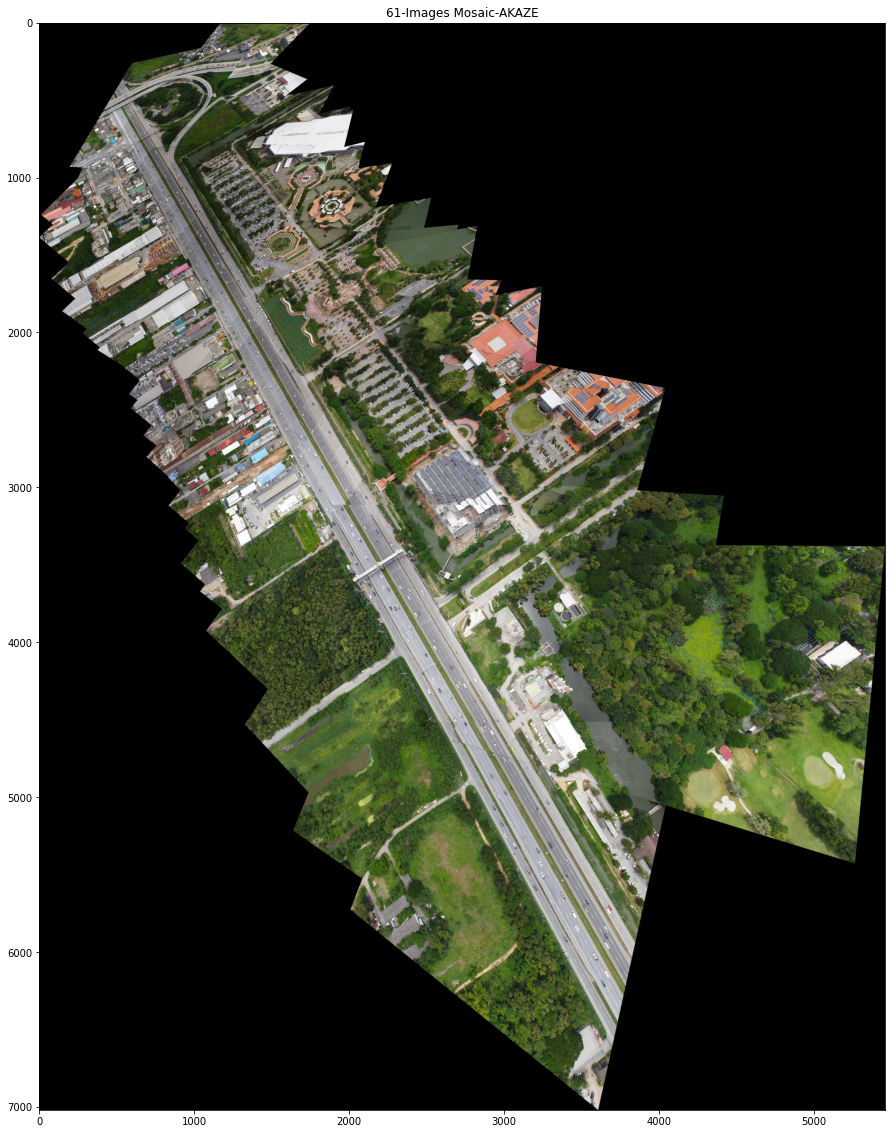

In [43]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_akaze , cv2.COLOR_BGR2RGB))
ax.set_title('61-Images Mosaic-AKAZE')